In [ ]:
import pandas as pd # library for data analysis
import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML documents
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
from datetime import datetime
import scipy.stats

In [ ]:
import warnings
warnings.filterwarnings("ignore")

### Read in Processed Tweets

In [ ]:
tweets = pd.read_csv("./tweet_output_predictions.csv")

In [ ]:
tweets = tweets[["Date", "Location", "Labels"]]

In [ ]:
tweets = tweets[tweets["Location"].str.contains(", United States")]

In [ ]:
tweets["State"] = tweets["Location"].apply(lambda x: x.split(",")[0])

In [ ]:
tweets.Labels.unique()

array(['Neutral', 'Irrelevant', 'Positive', 'Negative'], dtype=object)

In [ ]:
tweets.State = tweets.State.apply(lambda x: x.strip())

In [ ]:
tweets = tweets[tweets.Labels != "Irrelevant"]

In [ ]:
conditions = [
    tweets['Labels'] == "Positive",
    tweets['Labels'] == "Neutral",
    tweets["Labels"] == "Negative"
]

choices = [1,0, -1]

tweets['Labels'] = np.select(conditions, choices, default=0)

In [ ]:
tweets.Date = tweets.Date.apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S+00:00').strftime('%Y'))

In [ ]:
tweets["Count"] = 1

In [ ]:
tweets_grouped = tweets.groupby(["Date", "State"]).agg({'Labels':'mean', 'Count':'sum'}).reset_index()

### Presidential election results

In [ ]:
# get the response in the form of html
wikiurl="https://en.wikipedia.org/wiki/List_of_United_States_presidential_election_results_by_state"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)

In [ ]:
soup = BeautifulSoup(response.text, 'html.parser')
states=soup.find('table',{'class':"wikitable"})

In [ ]:
state_df=pd.read_html(str(states)) #into list
state_df=pd.DataFrame(state_df[0]) #into dataframe

In [ ]:
state_df.columns = state_df.iloc[0]

In [ ]:
state_df = state_df.iloc[1:] #drop the first row since we already established it as the header

In [ ]:
state_df = state_df[["State", "2016 ‡", "2020"]] #only get the last two presidential elections

In [ ]:
state_df = state_df.loc[:,~state_df.columns.duplicated(keep = 'first')]

In [ ]:
state_df = state_df.dropna()
state_df = state_df[state_df.State != 'State']

In [ ]:
state_df.head()

,State,2016 ‡,2020
1,Alabama,R,R
2,Alaska,R,R
3,Arizona,R,D
4,Arkansas,R,R
5,California,D,D


In [ ]:
state_df.rename(columns = {"2016 ‡":"2016"}, inplace = True)

In [ ]:
changed_states = []

for index, state in state_df.iterrows():
    if not state['2016'] == state["2020"]:
        changed_states.append(state["State"])

In [ ]:
state_df.loc[state_df['State'].isin(changed_states)]

,State,2016,2020
3,Arizona,R,D
11,Georgia,R,D
23,Michigan,R,D
40,Pennsylvania,R,D
51,Wisconsin,R,D


#### Merge with tweet sentiment

In [ ]:
rstate_2016_pres = state_df[state_df["2016"] == "R"]["State"].tolist()
rstate_2020_pres = state_df[state_df["2020"] == "R"]["State"].tolist()

In [ ]:
tweets_grouped_president = tweets_grouped.copy()

In [ ]:
conditions = [
    tweets_grouped['Date'] == "2020",
    tweets_grouped['Date'] != "2020"
]

choices = ["Previous election", "Current election"]

tweets_grouped_president['Date'] = np.select(conditions, choices, default=0)

In [ ]:
conditions = [
    tweets_grouped['Date'] == "2020",
    tweets_grouped['Date'] != "2020"
]

choices = ["Previous election", "Current election"]

tweets_grouped_president['Date'] = np.select(conditions, choices, default=0)

In [ ]:
tweets_grouped_president["political_affiliation"] = None

In [ ]:
for i in range(len(tweets_grouped_president)):
    if tweets_grouped_president["Date"][i] == "Previous election":
        if tweets_grouped_president["State"][i] in rstate_2016_pres:
            tweets_grouped_president["political_affiliation"][i] = "R"
        else:
            tweets_grouped_president["political_affiliation"][i] = "D"
    else:
        if tweets_grouped_president["State"][i] in rstate_2020_pres:
            tweets_grouped_president["political_affiliation"][i] = "R"
        else:
            tweets_grouped_president["political_affiliation"][i] = "D"

In [ ]:
tweets_grouped_president_all = tweets_grouped_president.copy()

In [ ]:
tweets_grouped_president = tweets_grouped_president.groupby(["Date", "political_affiliation"]).agg({'Labels':'mean', 'Count':'sum'}).reset_index()

In [ ]:
order_list = ['Previous election', 'Current election']

In [ ]:
red_blue = ['#ff0000','#0000ff']
blue_red = ['#0000ff','#ff0000']

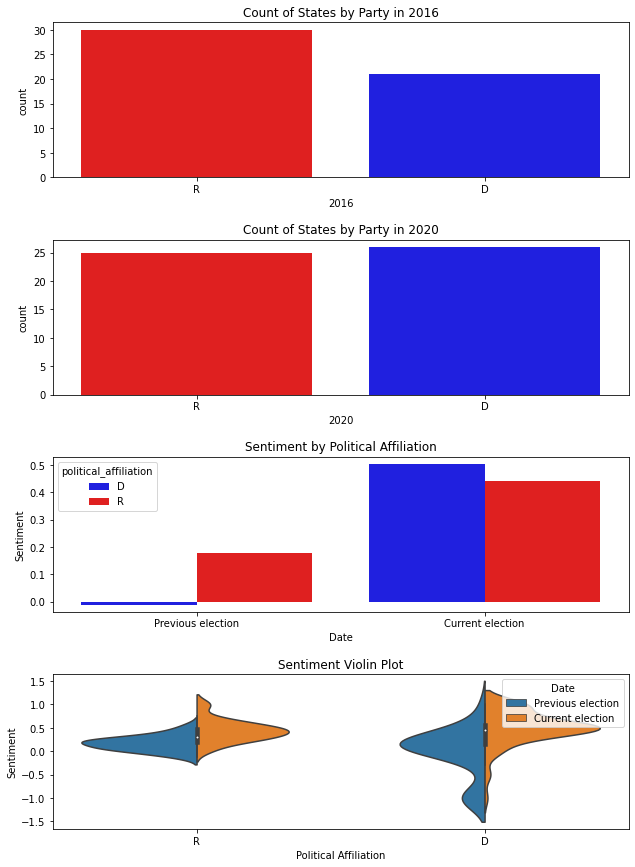

In [ ]:
fig, ax = plt.subplots(4)
sns.countplot(state_df['2016'],
              ax=ax[0],
              palette=sns.color_palette(red_blue, 2)).set(title='Count of States by Party in 2016')
sns.countplot(state_df['2020'],
              ax=ax[1],
              palette=sns.color_palette(red_blue, 2)).set(title='Count of States by Party in 2020')
sns.barplot(x = tweets_grouped_president["Date"],
            y = tweets_grouped_president["Labels"],
            hue = tweets_grouped_president["political_affiliation"],
            order = order_list,
            ax = ax[2],
            palette=sns.color_palette(blue_red, 2)).set(title = "Sentiment by Political Affiliation", ylabel = "Sentiment")
sns.violinplot(x="political_affiliation",
               y="Labels",
               hue="Date",
               data=tweets_grouped_president_all,
               kind="violin",
               split=True,
               height=4,
               aspect=.7).set(title = "Sentiment Violin Plot", ylabel = "Sentiment", xlabel = "Political Affiliation")

fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.8,
                    hspace=0.4)
fig.set_figwidth(10)
fig.set_figheight(14)

In [ ]:
tweets_grouped_president_all.head()

,Date,State,Labels,Count,political_affiliation
0,Previous election,Alabama,0.078947,76,R
1,Previous election,Alaska,0.240000,25,R
2,Previous election,Arenal,-1.000000,1,D
3,Previous election,Arizona,0.093385,257,R
4,Previous election,Arkansas,0.190476,21,R


In [ ]:
#rng = np.random.default_rng()

In [ ]:
red_2016 = tweets_grouped_president_all[(tweets_grouped_president_all["Date"] == "Previous election") & (tweets_grouped_president_all["political_affiliation"] == "R")]["Labels"]
blue_2016 = tweets_grouped_president_all[(tweets_grouped_president_all["Date"] == "Previous election") & (tweets_grouped_president_all["political_affiliation"] == "D")]["Labels"]

In [ ]:
scipy.stats.ttest_ind(red_2016, blue_2016)

Ttest_indResult(statistic=1.804211271015338, pvalue=0.07639136281474099)

In [ ]:
red_2020 = tweets_grouped_president_all[(tweets_grouped_president_all["Date"] == "Current election") & (tweets_grouped_president_all["political_affiliation"] == "R")]["Labels"]
blue_2020 = tweets_grouped_president_all[(tweets_grouped_president_all["Date"] == "Current election") & (tweets_grouped_president_all["political_affiliation"] == "D")]["Labels"]

In [ ]:
scipy.stats.ttest_ind(red_2020, blue_2020)

Ttest_indResult(statistic=-1.0284874686225798, pvalue=0.30587893617478396)

### Governors

In [ ]:
# get the response in the form of html
wikiurl="https://en.wikipedia.org/wiki/List_of_current_United_States_governors"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)

In [ ]:
soup = BeautifulSoup(response.text, 'html.parser')
governors=soup.find('table',{'class':"wikitable"})

In [ ]:
governors=pd.read_html(str(governors)) #into list
governors=pd.DataFrame(governors[0]) #into dataframe

In [ ]:
governors.columns = governors.columns.droplevel(0)

In [ ]:
governors = governors[["State", "Party.1"]]

In [ ]:
governors['Party.1'] = governors['Party.1'].replace(['Democratic–Farmer–Labor'],'Democratic')
governors['Party.1'] = governors['Party.1'].replace(['Republican[note 1]'],'Republican')

In [ ]:
tweets_grouped_state = tweets_grouped.copy()

In [ ]:
tweets_grouped_state = tweets_grouped_state[["State", "Labels"]].groupby("State").mean().reset_index()

In [ ]:
governor_sentiment = governors.merge(tweets_grouped_state, on = "State", how = "left")

In [ ]:
governor_sentiment.dropna(inplace = True)

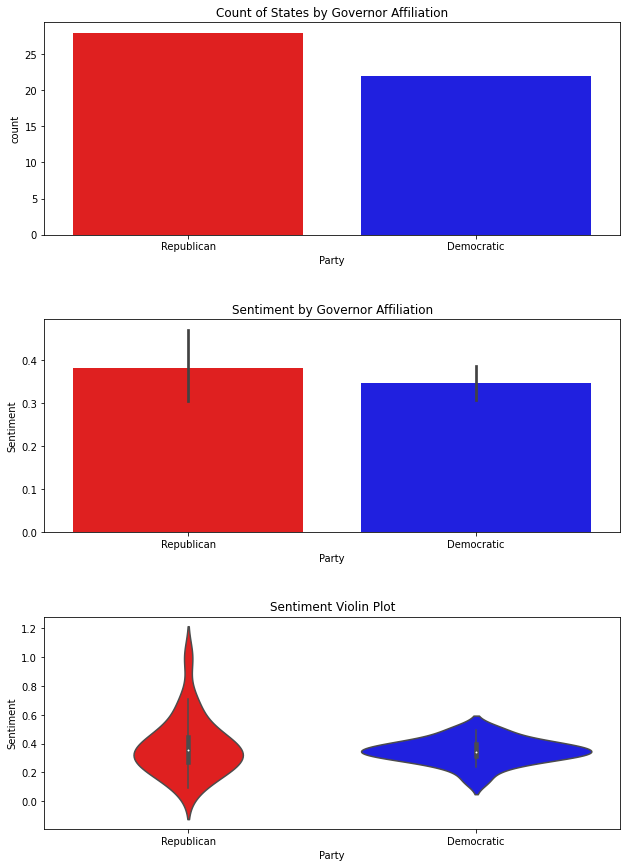

In [ ]:
fig, ax = plt.subplots(3)
sns.countplot(governors['Party.1'],
              ax = ax[0],
              palette=sns.color_palette(red_blue, 2)).set(xlabel = "Party",
                              title = "Count of States by Governor Affiliation")
sns.barplot(x = governor_sentiment['Party.1'],
            y = governor_sentiment.Labels,
            ax = ax[1],
            palette=sns.color_palette(red_blue, 2)).set(title = "Sentiment by Governor Affiliation",
                            xlabel = "Party",
                            ylabel = "Sentiment")
sns.violinplot(y = governor_sentiment["Labels"],
               x = governor_sentiment["Party.1"],
               ax = ax[2],
               palette=sns.color_palette(red_blue, 2)).set(title = "Sentiment Violin Plot",
                               xlabel = "Party",
                               ylabel = "Sentiment")

fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.8,
                    hspace=0.4)
fig.set_figwidth(10)
fig.set_figheight(14)

In [ ]:
governor_sentiment

,State,Party.1,Labels
0,Alabama,Republican,0.299784
1,Alaska,Republican,0.487743
2,Arizona,Republican,0.172021
3,Arkansas,Republican,0.253728
4,California,Democratic,0.370379
5,Colorado,Democratic,0.365240
7,Delaware,Democratic,0.408120
8,Florida,Republican,0.173856
9,Georgia,Republican,0.300910
10,Hawaii,Democratic,0.250242


In [ ]:
governor_r = governor_sentiment[governor_sentiment["Party.1"] == "Republican"]["Labels"]
governor_d = governor_sentiment[governor_sentiment["Party.1"] == "Democratic"]["Labels"]

In [ ]:
scipy.stats.ttest_ind(governor_r, governor_d)

Ttest_indResult(statistic=0.6897849980553925, pvalue=0.4944137002922502)

### State Legislature Majority

In [ ]:
# https://ballotpedia.org/Election_results,_2021:_Party_control_of_state_legislatures

wikiurl="https://ballotpedia.org/Election_results,_2021:_Party_control_of_state_legislatures"
table_class="marqueetable sortable jquery-tablesorter"
response=requests.get(wikiurl)

In [ ]:
soup = BeautifulSoup(response.text, 'html.parser')

In [ ]:
state_legislature =soup.find('table',{'class':"marqueetable"})

In [ ]:
state_legislature=pd.read_html(str(state_legislature)) #into list
state_legislature=pd.DataFrame(state_legislature[0]) #into dataframe

In [ ]:
state_legislature.columns = state_legislature.columns.droplevel(0).droplevel(0)
state_legislature = state_legislature[["State", "State Senate", "State House"]]

In [ ]:
state_legislature = state_legislature.loc[:,~state_legislature.columns.duplicated(keep = 'last')]

In [ ]:
state_legislature.head()

,State,State Senate,State House
0,Alabama,Republican,Republican
1,Alaska,Republican,Split
2,Arizona,Republican,Republican
3,Arkansas,Republican,Republican
4,California,Democratic,Democratic


In [ ]:
state_senate = state_legislature[["State", "State Senate"]]
state_house = state_legislature[["State", "State House"]]

In [ ]:
state_senate_sentiment = state_senate.merge(tweets_grouped_state, on = "State", how = "left").dropna()
state_house_sentiment = state_house.merge(tweets_grouped_state, on = "State", how = "left").dropna()

In [ ]:
red_grey_blue = ['#ff0000','darkgray','#0000ff']

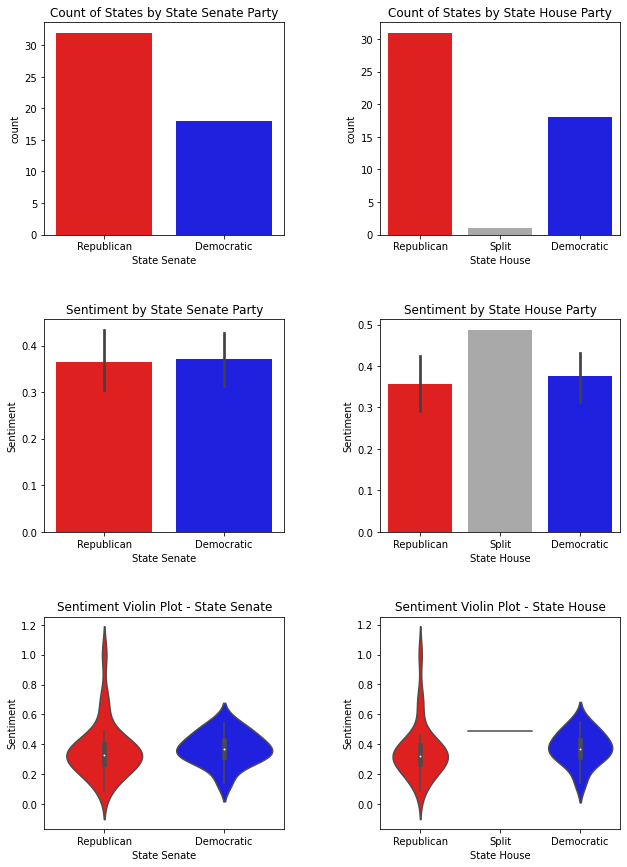

In [ ]:
fig, ax = plt.subplots(3,2)
sns.countplot(state_legislature['State Senate'],
              ax=ax[0,0],
              palette=sns.color_palette(red_blue, 2)).set(title = "Count of States by State Senate Party")
sns.countplot(state_legislature['State House'],
              ax=ax[0,1],
              palette = sns.color_palette(red_grey_blue, 3)).set(title = "Count of States by State House Party")
sns.barplot(x = state_senate_sentiment["State Senate"],
            y = state_senate_sentiment["Labels"],
            ax = ax[1,0],
            palette=sns.color_palette(red_blue, 2)).set(title = "Sentiment by State Senate Party",
                              ylabel = "Sentiment")
sns.barplot(x = state_house_sentiment["State House"],
            y = state_house_sentiment["Labels"],
            ax=ax[1,1],
            palette = sns.color_palette(red_grey_blue, 3)).set(title = "Sentiment by State House Party",
                            ylabel = "Sentiment")
sns.violinplot(x = state_senate_sentiment["State Senate"],
               y = state_senate_sentiment["Labels"],
               ax = ax[2,0],
               palette=sns.color_palette(red_blue, 2)).set(title = "Sentiment Violin Plot - State Senate",
                                 ylabel = "Sentiment")
sns.violinplot(x = state_house_sentiment["State House"],
               y = state_house_sentiment["Labels"],
               ax=ax[2,1],
               palette = sns.color_palette(red_grey_blue, 3)).set(title = "Sentiment Violin Plot - State House",
                               ylabel = "Sentiment")
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
fig.set_figwidth(10)
fig.set_figheight(14)

In [ ]:
senate_red = state_senate_sentiment[state_senate_sentiment["State Senate"] == "Republican"]["Labels"]
senate_blue = state_senate_sentiment[state_senate_sentiment["State Senate"] == "Democratic"]["Labels"]

In [ ]:
scipy.stats.ttest_ind(senate_red, senate_blue)

Ttest_indResult(statistic=-0.13944006240994453, pvalue=0.8898200242303544)

In [ ]:
house_red = state_house_sentiment[state_house_sentiment["State House"] == "Republican"]["Labels"]
house_blue = state_house_sentiment[state_house_sentiment["State House"] == "Democratic"]["Labels"]

In [ ]:
scipy.stats.ttest_ind(house_red, house_blue)

Ttest_indResult(statistic=-0.33019576473630513, pvalue=0.7430656139410645)

In [ ]:
scipy.version.version


'1.7.3'